In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from theano import shared as tshared
import theano.tensor as tt
from theano import function, printing
import arviz as az

# Random seed
np.random.seed(713)

## Infer Emulation errors using LF and HF points


In [2]:
# (LF points, HF points, mean errors, max errors)
data = np.loadtxt("../budget_size/bugdget_size.txt")

The parametric model is

$$
\mathrm{error} = \theta \cdot n_\mathrm{LF}^{- \nu / d} + n_\mathrm{HF}^{- \nu / d}
$$

In [3]:
data.shape

(56, 5)

In [4]:
x_train = data[:, [0, 1]]
y_train = data[:, [2]]
y_sigma = data[:, [3]]

y_max = data[:, [4]]

# dimensionality of the emulator
d = 5

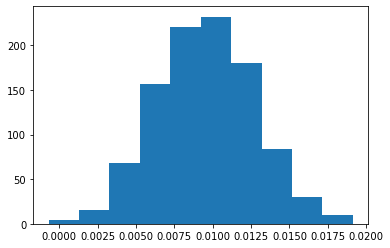

In [5]:
plt.hist(pm.Normal.dist(mu=y_train.mean(), sigma=y_train.std()).random(size=1000));

In [6]:
with pm.Model() as budget_model:
    theta = pm.Normal("theta", mu=y_train.mean(), sigma=y_train.std())

    rho   = pm.Uniform("rho", 0, 150)

    # InverseGamma has nice properties:
    # it's continuous and has support x ∈ (0, inf)
    nu1 = pm.Uniform("nu1", 0, 15)
#     nu2 = pm.InverseGamma("nu2", alpha=2, beta=1)

    y = theta * ( rho * x_train[:, 0] ** (- nu1 / d) +  x_train[:, 1] ** (- nu1 / d)) 

    pm.Normal("likelihood", mu=y, sigma=y_sigma[:, 0], observed=y_train[:, 0])

In [7]:
with budget_model:
    trace = pm.sample(10000, tune=10000, )

/home/jibancat/.pyenv/versions/miniconda3-4.7.12/envs/pymc3_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu1, rho, theta]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 39 seconds.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
There were 443 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6441828050041022, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


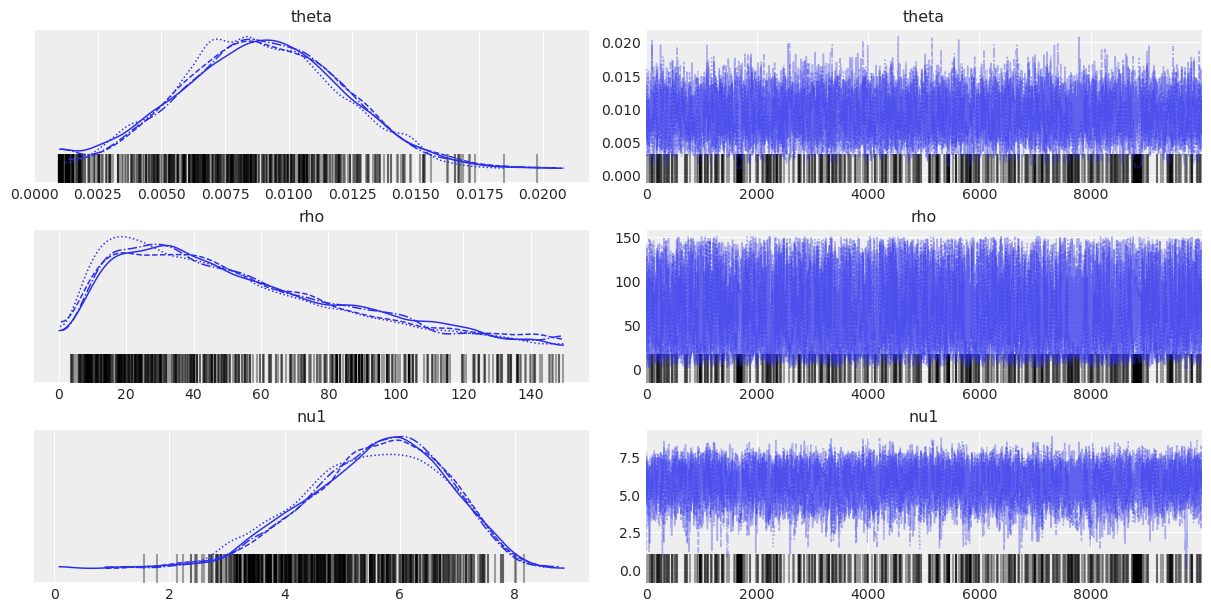

In [8]:
# plotting setting to make the arviz plots look less buggy
az.style.use("arviz-darkgrid")

with budget_model:
    rvs = ["theta", "rho", "nu1", ]

    _ = az.plot_trace(trace, var_names=rvs)

In [9]:
pm.stats.hdi(trace["rho"], hdi_prob=0.1)

array([13.43760076, 21.86234554])

In [34]:
n_lf = x_train[:, 0]
n_hf = x_train[:, 1]

y_true = y_train[:, 0]

# theta_mode = stats.mode(trace["theta"], axis=0).mode[0]
# rho_mode   = stats.mode(trace["rho"], axis=0).mode[0]
# nu_mode    = stats.mode(trace["nu1"], axis=0).mode[0]

theta_mode = np.median(trace["theta"])
rho_mode   = np.median(trace["rho"])
nu_mode    = np.median(trace["nu1"])


theta_lower, theta_mode, theta_upper = np.quantile(trace["theta"], [0.25, 0.5, 0.75])
nu_lower, nu_mode, nu_upper       = np.quantile(trace["nu1"], [0.25, 0.5, 0.75])
rho_lower, rho_mode, rho_upper       = np.quantile(trace["rho"], [0.25, 0.5, 0.75])
# theta_mode = np.mean(trace["theta"], axis=0)
# rho_mode   = np.mean(trace["rho"], axis=0)
# nu_mode    = np.mean(trace["nu1"], axis=0)

# theta_mode = np.median(pm.stats.hdi(trace["theta"], hdi_prob=0.1))
# rho_mode   = np.median(pm.stats.hdi(trace["rho"], hdi_prob=0.1))
# nu_mode    = np.median(pm.stats.hdi(trace["nu1"], hdi_prob=0.1))


y_pred = theta_mode * (
    rho_mode * n_lf ** (- nu_mode / d )
 +             n_hf ** (- nu_mode / d )
)

y_pred_lower = theta_lower * (
    rho_lower * n_lf ** (- nu_upper / d )
 +              n_hf ** (- nu_upper / d )
)

y_pred_upper = theta_upper * (
    rho_upper * n_lf ** (- nu_lower / d )
 +              n_hf ** (- nu_lower / d )
)

print(rho_mode, nu_mode, theta_mode)

50.87333463864485 5.667590990614169 0.00889705216141875


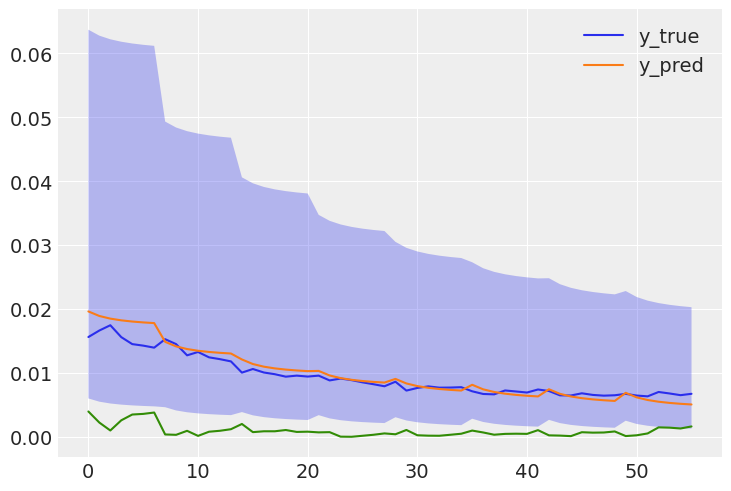

In [45]:
# n_lf + (512/128)**3 * n_hf

plt.plot(y_true, label="y_true")
plt.plot(y_pred, label="y_pred")

plt.fill_between(range(len(y_true)), y1=y_pred_lower, y2=y_pred_upper, alpha=0.3)

plt.plot(np.abs(y_pred - y_true))

plt.legend()

In [20]:
np.quantile(trace["theta"], [0.25, 0.5, 0.75])

array([0.0067614 , 0.00889705, 0.01110199])

In [19]:
np.quantile(trace["nu1"], [0.25, 0.5, 0.75])

array([4.7733144 , 5.66759099, 6.46416153])

In [18]:
np.quantile(trace["rho"], [0.25, 0.5, 0.75])

array([27.3907506 , 50.87333464, 85.08977266])

In [47]:
budget_size_fn = lambda num_lf, num_hf, theta, rho, nu : theta * (rho * num_lf ** (- nu / 5) + num_hf ** (- nu / 5)) 

In [56]:
budget_size_fn(60, 6, theta_mode, rho_mode, nu_mode)

0.00553420318436133

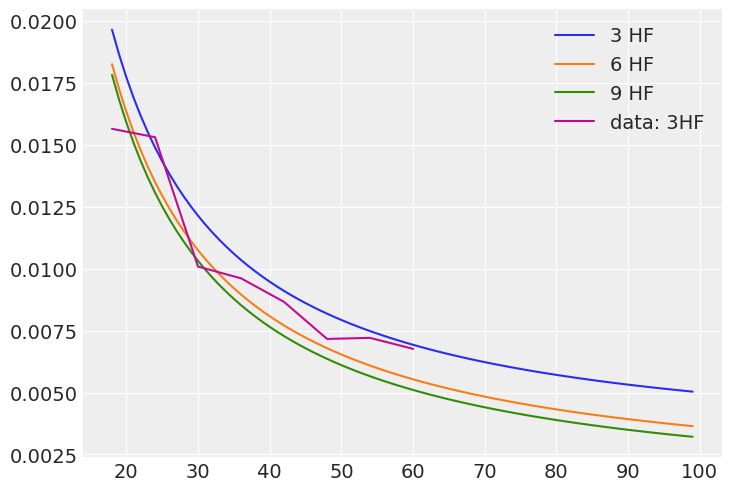

In [88]:
all_n_lfs = np.arange(18, 100)

ind = x_train[:, 1] == 3
data_lf    = x_train[ind, 0]
data_error = y_train[ind, 0]

plt.plot(all_n_lfs, budget_size_fn(all_n_lfs, 3, theta_mode, rho_mode, nu_mode), label="3 HF")
plt.plot(all_n_lfs, budget_size_fn(all_n_lfs, 6, theta_mode, rho_mode, nu_mode), label="6 HF")
plt.plot(all_n_lfs, budget_size_fn(all_n_lfs, 9, theta_mode, rho_mode, nu_mode), label="9 HF")

plt.plot(data_lf, data_error, label="data: 3HF")

plt.legend()

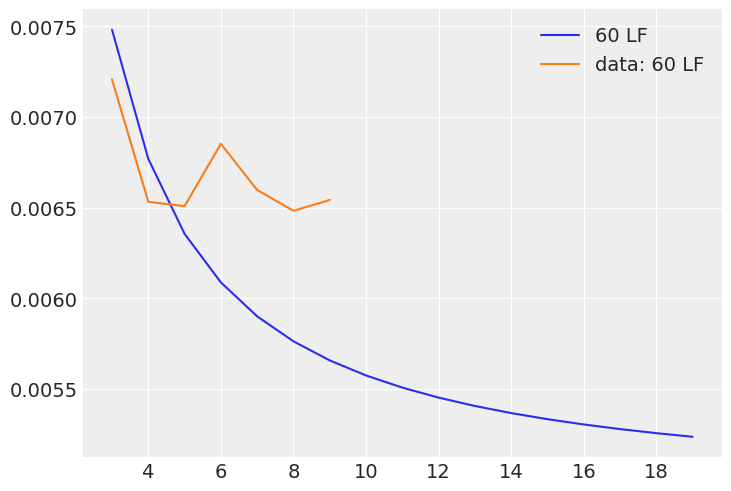

In [89]:
all_n_hfs = np.arange(3, 20)

num_lf = 54

ind = x_train[:, 0] == num_lf
data_hf    = x_train[ind, 1]
data_error = y_train[ind, 0]

plt.plot(all_n_hfs, budget_size_fn(num_lf, all_n_hfs, theta_mode, rho_mode, nu_mode), label="60 LF")
# plt.plot(all_n_hfs, budget_size_fn(60, all_n_hfs, theta_mode, rho_mode, nu_mode), label="50 LF")
# plt.plot(all_n_hfs, budget_size_fn(60, all_n_hfs, theta_mode, rho_mode, nu_mode), label="40 LF")

plt.plot(data_hf, data_error, label="data: 60 LF")

plt.legend()
